# Imports

In [65]:
#Libraries
from WebScraperPageCount import WebScraper
import pandas as pd
import numpy as np
import os
import fnmatch
import tempfile
import psycopg2
from sqlalchemy import create_engine

os.environ['MPLCONFIGDIR'] = "/home/jovyan"
import matplotlib.pyplot as plt



## 1. Daten scrapen, Dataframe erstellen

In [ ]:
dfImmo = WebScraper().runImmo()
dfHome = WebScraper().runHome()



In [ ]:
dfImmo.head(5)
   


In [ ]:
dfHome.head(5)



In [ ]:
data = pd.concat([dfImmo, dfHome])
data.head(5)




In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   display(data)

In [ ]:
data.to_excel('Output.xlsx', index=False)

## 2. Datenbereinigung

In [ ]:
data.describe()

#### 2.1 Leere und falsche Adresseinträge auf NaN setzen

In [ ]:
data_work = data
data_work['Street'].replace('', np.nan, inplace=True)
data_work['Street'].replace('None', np.nan, inplace=True)
data_work['Street'].replace('.', np.nan, inplace=True)
data_work['Street'].replace('44', np.nan, inplace=True)
data_work['Street'].replace('70', np.nan, inplace=True)
data_work['Price [CHF]'].replace('None', np.nan, inplace=True)

In [ ]:
data_work.describe()

#### 2.2 Nan Einträge löschen

In [ ]:
data_work.dropna(subset=['Street','Price [CHF]'], inplace=True)

In [ ]:
data_work.describe()

#### 2.3 Duplikate anhand von Adresse und Preis entfernen

In [ ]:
data_cleansed = data_work.drop_duplicates(subset=['Price [CHF]', 'Street'])
data_cleansed.describe()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
   display(data_cleansed)

## 3. Datenbank

#### 3.1 Verbindung zu Datenbank herstellen

In [66]:
conn = psycopg2.connect("host=db dbname=ads_project_db user=admin password=secret")

#### 3.2 Bereinigte Daten in Datenbank schreiben

In [67]:
engine = create_engine('postgresql://admin:secret@db:5432/ads_project_db')
data_cleansed.to_sql('immo_data', engine, if_exists='replace')

NameError: name 'data_cleansed' is not defined

#### 3.3 SQL Abfrage Stadt Zürich

In [68]:
my_table    = pd.read_sql('''select 
                          "Size [m²]",
                          "Number of Rooms",
                          "Price [CHF]",
                          "Street",
                          "Zip Code",
                          "City",
                          "State",
                          "Latitude",
                          "Longitude"
                          from immo_data
                          where "City" = 'Zürich' ''', conn)
print (my_table)

    Size [m²] Number of Rooms Price [CHF]                   Street Zip Code   
0          61             2.5        3480         Limmatstrasse 27     8005  \
1         100             3.5        5190        Dufourstrasse 131     8008   
2          58             2.5        3460  Schaffhauserstrasse 439     8050   
3          35             1.5        1620    Bernerstrasse Süd 167     8048   
4         135             3.5        7150          Kraftstrasse 37     8044   
..        ...             ...         ...                      ...      ...   
126        97               4        2350  Schaffhauserstrasse 457     8052   
127      None               3        2410   Albisriederstrasse 180     8047   
128      None             5.5        2390       Koschenrütistr. 59     8052   
129        67               3        2190   Friesenbergstrasse 131     8055   
130        66               3        2790          Weizenstrasse 8     8037   

       City   State          Latitude         Longi

/tmp/ipykernel_85/2074431485.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  my_table    = pd.read_sql('''select


In [ ]:
import psycopg2.extras
cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

cur.execute("""select *
               from information_schema.columns
               where table_schema NOT IN ('information_schema', 'pg_catalog')
               order by table_schema, table_name""")

for row in cur:
    print( "schema: {schema}, table: {table}, column: {col}, type: {type}".format(
        schema = row['table_schema'], table = row['table_name'],
        col = row['column_name'], type = row['data_type']))

In [ ]:
cur.execute("""ALTER TABLE immo_data 
ALTER COLUMN "Number of Rooms" TYPE float USING "Number of Rooms"::float,
ALTER COLUMN "Size [m²]" TYPE float USING "Size [m²]"::float,
ALTER COLUMN "Price [CHF]" TYPE float USING "Number of Rooms"::float,
ALTER COLUMN "Zip Code" TYPE integer USING "Zip Code"::integer,
ALTER COLUMN "Latitude" TYPE float USING "Latitude"::float,
ALTER COLUMN "Longitude" TYPE float USING "Longitude"::float;""")


## 4. Verwendung Geopgraphische Daten

#### 4.1 Info Tag Generieren

In [69]:
my_table["tag_info"] = "Fläche [m²]: " + my_table['Size [m²]'].astype(str) + "\n" + "Anz. Räume: " + my_table['Number of Rooms'].astype(str) + "\n" + "Preis: " + my_table['Price [CHF]'].astype(str)
my_table

,Size [m²],Number of Rooms,Price [CHF],Street,Zip Code,City,State,Latitude,Longitude,tag_info
0,61,2.5,3480,Limmatstrasse 27,8005,Zürich,Zurich,47.3809288835372,8.53611587674714,Fläche [m²]: 61\nAnz. Räume: 2.5\nPreis: 3480
1,100,3.5,5190,Dufourstrasse 131,8008,Zürich,Zurich,47.3572018,8.553168,Fläche [m²]: 100\nAnz. Räume: 3.5\nPreis: 5190
2,58,2.5,3460,Schaffhauserstrasse 439,8050,Zürich,Zurich,47.4166781,8.5446854,Fläche [m²]: 58\nAnz. Räume: 2.5\nPreis: 3460
3,35,1.5,1620,Bernerstrasse Süd 167,8048,Zürich,Zurich,47.39432,8.4866,Fläche [m²]: 35\nAnz. Räume: 1.5\nPreis: 1620
4,135,3.5,7150,Kraftstrasse 37,8044,Zürich,Zurich,47.3787617,8.5589028,Fläche [m²]: 135\nAnz. Räume: 3.5\nPreis: 7150
...,...,...,...,...,...,...,...,...,...,...
126,97,4,2350,Schaffhauserstrasse 457,8052,Zürich,None,47.4184095,8.5461811,Fläche [m²]: 97\nAnz. Räume: 4\nPreis: 2350
127,None,3,2410,Albisriederstrasse 180,8047,Zürich,None,47.3778891,8.4984539,Fläche [m²]: None\nAnz. Räume: 3\nPreis: 2410
128,None,5.5,2390,Koschenrütistr. 59,8052,Zürich,None,47.4248637,8.5371963,Fläche [m²]: None\nAnz. Räume: 5.5\nPreis: 2390
129,67,3,2190,Friesenbergstrasse 131,8055,Zürich,None,47.3656453,8.5099707,Fläche [m²]: 67\nAnz. Räume: 3\nPreis: 2190


In [70]:
geo_data = my_table[['Latitude','Longitude','tag_info']]
geo_data.head(5)



,Latitude,Longitude,tag_info
0,47.3809288835372,8.53611587674714,Fläche [m²]: 61\nAnz. Räume: 2.5\nPreis: 3480
1,47.3572018,8.553168,Fläche [m²]: 100\nAnz. Räume: 3.5\nPreis: 5190
2,47.4166781,8.5446854,Fläche [m²]: 58\nAnz. Räume: 2.5\nPreis: 3460
3,47.39432,8.4866,Fläche [m²]: 35\nAnz. Räume: 1.5\nPreis: 1620
4,47.3787617,8.5589028,Fläche [m²]: 135\nAnz. Räume: 3.5\nPreis: 7150


#### 4.2 Lat & Long in Float konertieren

In [71]:
geo_data["Latitude"] = pd.to_numeric(geo_data["Latitude"])
geo_data["Longitude"] = pd.to_numeric(geo_data["Longitude"])

/tmp/ipykernel_85/2080068777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_data["Latitude"] = pd.to_numeric(geo_data["Latitude"])
/tmp/ipykernel_85/2080068777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_data["Longitude"] = pd.to_numeric(geo_data["Longitude"])


#### 4.3 Wohnungen in Zürich mit Tags auf Karte darstellen

In [72]:
import folium

map = folium.Map(location=[geo_data.Latitude.mean(), 
                           geo_data.Longitude.mean()], 
                 zoom_start=12, 
                 control_scale=True)

# Add maker symbols
for index, location_info in geo_data.iterrows():
    folium.Marker([location_info["Latitude"], 
                   location_info["Longitude"]], 
                  popup=location_info["tag_info"]).add_to(map),
map

#### 4.4 Haltestellen der Schweiz über API von Opendata holen und in Json schreiben

In [73]:
import urllib
from urllib.request import urlopen
import pprint
import requests     # 2.18.4
import json         # 2.0.9
import pandas as pd # 0.23.0

packages = 'https://opendata.swiss/api/3/action/package_list'

response = requests.get(packages)

response_dict = json.loads(response.content)

# Check the contents of the response
assert response_dict['success'] is True  # make sure if response is OK
result = response_dict['result']         # extract all the packages from the response
# pprint.pprint(result)                    # pretty print the list to the screen

# Specify the package you are interested in:
package = 'dienststellen-gemass-opentransportdata-swiss'

# Base url for package information. This is always the same.
base_url = 'https://opendata.swiss/api/3/action/package_show?id='

# Construct the url for the package of interest
package_information_url = base_url + package

# Make the HTTP request
package_information = requests.get(package_information_url)

# Use the json module to load CKAN's response into a dictionary
package_dict = json.loads(package_information.content)

# Check the contents of the response.
assert package_dict['success'] is True  # again make sure if response is OK
package_dict = package_dict['result']   # we only need the 'result' part from the dictionary
# pprint.pprint(package_dict)             # pretty print the package information to screen

# Get the url for the data from the dictionary
data_url = package_dict['resources'][0]['url']
print('Data url:     ' + data_url)

# Print the data format
data_format = package_dict['resources'][0]['format']
print('Data format:  ' + data_format)

json_url = urlopen(data_url)
data = json.loads(json_url.read())

# with open('haltestellen.json', 'w') as outfile:
#     json.dump(data, outfile)




Data url:     https://data.sbb.ch/api/v2/catalog/datasets/dienststellen-gemass-opentransportdataswiss/exports/json
Data format:  JSON


#### 4.5 Nur benötigte Informationen aus JSON extrahieren und in DataFrame schreiben

In [74]:

columnCaptions = ['Haltestelle','Ort','PLZ','lon','lat']
keyValues = [['bezeichnung_offiziell'],
            ['gemeindename'],
            ['plz'],
            ['geopos','lon'],
            ['geopos','lat']]
infoMatrix = []

for info in data:
    row = []
    for currentKey in keyValues:
        jsonTemp = info
        for key in currentKey:
            try:
                jsonTemp = jsonTemp[key]
            except:
                jsonTemp = None
        row.append(jsonTemp)
    infoMatrix.append(row)
    

    

df_haltestellen_geo = pd.DataFrame(infoMatrix)

for i in range(len(columnCaptions)):
    df_haltestellen_geo.rename(columns={i: columnCaptions[i]}, inplace=True)
df_haltestellen_geo.head()


,Haltestelle,Ort,PLZ,lon,lat
0,"Heiligenschwendi,Unt.-Eichholz",Heiligenschwendi,3625,7.661140,46.752467
1,Hohsträss,Hasliberg,6084,8.236526,46.762043
2,"Ascona, Mirador",Ascona,6612,8.777570,46.150346
3,Jassbach,Linden,3673,7.699703,46.848556
4,"Biel/Bienne, Gottstatterhaus",Biel/Bienne,2505,7.216841,47.128482


In [75]:
df_haltestellen_geo['PLZ'] = pd.to_numeric(df_haltestellen_geo['PLZ'])
df_haltestellen_geo['lon'] = pd.to_numeric(df_haltestellen_geo['lon'])
df_haltestellen_geo['lat'] = pd.to_numeric(df_haltestellen_geo['lat'])

#### 4.6 Daten für Zürich aus DF holen

In [79]:
df_haltestellen_zurich = df_haltestellen_geo.loc[(df_haltestellen_geo['PLZ'] > 8000) & (df_haltestellen_geo['PLZ'] < 8080)]
df_haltestellen_zurich.head()

,Haltestelle,Ort,PLZ,lon,lat
2654,"Zürich, Klinik Hirslanden",Zürich,8008.0,8.576620,47.351775
2656,"Zürich, Kinderspital (ab 2024)",Zürich,8008.0,8.572308,47.352518
2672,"Zürich, Toblerplatz",Zürich,8044.0,8.559347,47.379090
2683,"Zürich, Schwamendingerplatz",Zürich,8051.0,8.571899,47.404593
2713,"Zürich, Lochergut",Zürich,8004.0,8.517516,47.375412


In [82]:
import folium

map = folium.Map(location=[geo_data.Latitude.mean(), 
                           geo_data.Longitude.mean()], 
                 zoom_start=12, 
                 control_scale=True)

# Add maker symbols
for index, location_info in geo_data.iterrows():
    folium.Marker([location_info["Latitude"], 
                   location_info["Longitude"]], 
                  popup=location_info["tag_info"]).add_to(map),

for index, location_info in df_haltestellen_zurich.iterrows():
    folium.Marker([location_info["lat"], 
                   location_info["lon"]], 
                  popup=location_info["Haltestelle"],
                 icon=folium.Icon(color='pink', icon='white')).add_to(map)
map

## 5. EDA

In [31]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### 5.1 Datenframes für gesamte Schweiz & Städte von interesse aus DB lesen, type conversions

In [19]:
data_switzerland = pd.read_sql('''select 
                          "Size [m²]",
                          "Number of Rooms",
                          "Price [CHF]",
                          "Street",
                          "Zip Code",
                          "City"
                          from immo_data''', conn)
data_switzerland["Size [m²]"] = pd.to_numeric(data_switzerland["Size [m²]"], errors='coerce')
data_switzerland["Number of Rooms"] = pd.to_numeric(data_switzerland["Number of Rooms"], errors='coerce')
data_switzerland["Price [CHF]"] = data_switzerland["Price [CHF]"].astype(float)
data_switzerland["Street"] = data_switzerland["Street"].astype(str)
data_switzerland["Zip Code"] = data_switzerland["Zip Code"].astype(int)
data_switzerland["City"] = data_switzerland["City"].astype(str)





/tmp/ipykernel_77/105764307.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_switzerland = pd.read_sql('''select


In [20]:
data_zurich = pd.read_sql('''select 
                          "Size [m²]",
                          "Number of Rooms",
                          "Price [CHF]",
                          "Street",
                          "Zip Code",
                          "City"
                          from immo_data
                          where "City" = 'Zürich' ''', conn)
data_zurich["Size [m²]"] = pd.to_numeric(data_zurich["Size [m²]"], errors='coerce')
data_zurich["Number of Rooms"] = pd.to_numeric(data_zurich["Number of Rooms"], errors='coerce')
data_zurich["Price [CHF]"] = data_zurich["Price [CHF]"].astype(float)
data_zurich["Street"] = data_zurich["Street"].astype(str)
data_zurich["Zip Code"] = data_zurich["Zip Code"].astype(int)
data_zurich["City"] = data_zurich["City"].astype(str)
data_zurich.head(5)

/tmp/ipykernel_77/3068066990.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_zurich = pd.read_sql('''select


,Size [m²],Number of Rooms,Price [CHF],Street,Zip Code,City
0,61.0,2.5,3480.0,Limmatstrasse 27,8005,Zürich
1,100.0,3.5,5190.0,Dufourstrasse 131,8008,Zürich
2,58.0,2.5,3460.0,Schaffhauserstrasse 439,8050,Zürich
3,35.0,1.5,1620.0,Bernerstrasse Süd 167,8048,Zürich
4,135.0,3.5,7150.0,Kraftstrasse 37,8044,Zürich


In [21]:
data_genf   = pd.read_sql('''select 
                          "Size [m²]",
                          "Number of Rooms",
                          "Price [CHF]",
                          "Street",
                          "Zip Code",
                          "City"
                          from immo_data
                          where "City" = 'Genève' ''', conn)
data_genf["Size [m²]"] = pd.to_numeric(data_genf["Size [m²]"], errors='coerce')
data_genf["Number of Rooms"] = pd.to_numeric(data_genf["Number of Rooms"], errors='coerce')
data_genf["Price [CHF]"] = data_genf["Price [CHF]"].astype(float)
data_genf["Street"] = data_genf["Street"].astype(str)
data_genf["Zip Code"] = data_genf["Zip Code"].astype(int)
data_genf["City"] = data_genf["City"].astype(str)
data_genf.head(5)

/tmp/ipykernel_77/3432066338.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_genf   = pd.read_sql('''select


,Size [m²],Number of Rooms,Price [CHF],Street,Zip Code,City
0,63.0,3.0,2470.0,Boulevard de Saint-Georges 46,1205,Genève
1,45.0,2.0,1650.0,Rue de la Tour-de-Boël 5,1204,Genève
2,58.0,2.0,1250.0,Rue Neuve-du-Molard 5,1204,Genève
3,93.0,4.0,3800.0,Avenue de Champel 73,1206,Genève
4,55.0,3.5,2230.0,Boulevard de Saint-Georges 46,1205,Genève


In [22]:
data_zug    = pd.read_sql('''select 
                          "Size [m²]",
                          "Number of Rooms",
                          "Price [CHF]",
                          "Street",
                          "Zip Code",
                          "City"
                          from immo_data
                          where "City" = 'Zug' ''', conn)
data_zug["Size [m²]"] = pd.to_numeric(data_zug["Size [m²]"], errors='coerce')
data_zug["Number of Rooms"] = pd.to_numeric(data_zug["Number of Rooms"], errors='coerce')
data_zug["Price [CHF]"] = data_zug["Price [CHF]"].astype(float)
data_zug["Street"] = data_zug["Street"].astype(str)
data_zug["Zip Code"] = data_zug["Zip Code"].astype(int)
data_zug["City"] = data_zug["City"].astype(str)
data_zug.head(5)

/tmp/ipykernel_77/2933865956.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_zug    = pd.read_sql('''select


,Size [m²],Number of Rooms,Price [CHF],Street,Zip Code,City
0,100,2.5,4700.0,Baarerstrasse 11,6300,Zug
1,85,4.0,5700.0,Gartenstrasse 7,6300,Zug
2,135,4.5,5900.0,General-Guisan-Strasse 13,6300,Zug
3,68,2.5,4800.0,Aegeristrasse,6300,Zug
4,52,1.5,1485.0,Haldenstrasse 2/4,6300,Zug


In [23]:
data_stgallen   = pd.read_sql('''select 
                          "Size [m²]",
                          "Number of Rooms",
                          "Price [CHF]",
                          "Street",
                          "Zip Code",
                          "City"
                          from immo_data
                          where "City" = 'St. Gallen' ''', conn)
data_stgallen["Size [m²]"] = pd.to_numeric(data_stgallen["Size [m²]"], errors='coerce')
data_stgallen["Number of Rooms"] = pd.to_numeric(data_stgallen["Number of Rooms"], errors='coerce')
data_stgallen["Price [CHF]"] = data_stgallen["Price [CHF]"].astype(float)
data_stgallen["Street"] = data_stgallen["Street"].astype(str)
data_stgallen["Zip Code"] = data_stgallen["Zip Code"].astype(int)
data_stgallen["City"] = data_stgallen["City"].astype(str)
data_stgallen.head(5)

/tmp/ipykernel_77/3911441888.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_stgallen   = pd.read_sql('''select


,Size [m²],Number of Rooms,Price [CHF],Street,Zip Code,City
0,100.0,3.5,2450.0,"Miete ALL IN, St. Georgen Strasse 20",9000,St. Gallen
1,90.0,3.5,2300.0,"Miete ALL IN , Ruhsitzstrasse 31",9000,St. Gallen
2,45.0,2.5,1600.0,Ruhsitzstrasse 31,9000,St. Gallen
3,80.0,2.5,1600.0,"Wohnung mit Service, Wildeggstrasse 16",9000,St. Gallen
4,100.0,3.5,2450.0,Wohnen mit Service St. Georgen Strasse 20,9000,St. Gallen


In [24]:
data_winterthur  = pd.read_sql('''select 
                          "Size [m²]",
                          "Number of Rooms",
                          "Price [CHF]",
                          "Street",
                          "Zip Code",
                          "City"
                          from immo_data
                          where "City" = 'Winterthur' ''', conn)
data_winterthur["Size [m²]"] = pd.to_numeric(data_winterthur["Size [m²]"], errors='coerce')
data_winterthur["Number of Rooms"] = pd.to_numeric(data_winterthur["Number of Rooms"], errors='coerce')
data_winterthur["Price [CHF]"] = data_winterthur["Price [CHF]"].astype(float)
data_winterthur["Street"] = data_winterthur["Street"].astype(str)
data_winterthur["Zip Code"] = data_winterthur["Zip Code"].astype(int)
data_winterthur["City"] = data_winterthur["City"].astype(str)
data_winterthur.head(5)

/tmp/ipykernel_77/2786579643.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_winterthur  = pd.read_sql('''select


,Size [m²],Number of Rooms,Price [CHF],Street,Zip Code,City
0,60.0,3.0,1656.0,Sulzbergstrasse 8,8400,Winterthur
1,NaN,3.0,1385.0,Im Geissacker 37,8404,Winterthur
2,82.0,3.5,2380.0,Römertorstrasse 2,8404,Winterthur
3,132.0,3.5,3950.0,Marktgasse 39,8400,Winterthur
4,116.0,4.5,2600.0,Hofstettweg 5,8405,Winterthur


In [25]:
data_biel  = pd.read_sql('''select 
                          "Size [m²]",
                          "Number of Rooms",
                          "Price [CHF]",
                          "Street",
                          "Zip Code",
                          "City"
                          from immo_data
                          where "City" = 'Biel' ''', conn)
data_biel["Size [m²]"] = pd.to_numeric(data_biel["Size [m²]"], errors='coerce')
data_biel["Number of Rooms"] = pd.to_numeric(data_biel["Number of Rooms"], errors='coerce')
data_biel["Price [CHF]"] = data_biel["Price [CHF]"].astype(float)
data_biel["Street"] = data_biel["Street"].astype(str)
data_biel["Zip Code"] = data_biel["Zip Code"].astype(int)
data_biel["City"] = data_biel["City"].astype(str)
data_biel.head(5)

/tmp/ipykernel_77/1051902830.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_biel  = pd.read_sql('''select


,Size [m²],Number of Rooms,Price [CHF],Street,Zip Code,City
0,103.0,3.5,1950.0,Bahnhofstrasse 34,2502,Biel
1,67.0,3.5,1350.0,Madretschstr. 108,2503,Biel
2,NaN,4.5,1865.0,Südstrasse 45,2504,Biel
3,50.0,2.0,990.0,Bözingenstrasse 134,2504,Biel
4,95.0,4.5,1950.0,Seevorstadt 44,2502,Biel


#### 5.2 NaN herauslöschen

In [26]:
data_switzerland.dropna(how='any', inplace= True)
data_zurich.dropna(how='any', inplace= True)
data_genf.dropna(how='any', inplace= True)
data_zug.dropna(how='any', inplace= True)
data_stgallen.dropna(how='any', inplace= True)
data_winterthur.dropna(how='any', inplace= True)
data_biel.dropna(how='any', inplace= True)

#### 5.3 Zusätzliche Variablen erstellen

In [35]:
data_switzerland.info()
data_switzerland["Quadratmeterpreis"] = data_switzerland["Preis [CHF]"]/data_switzerland["Size [m²]"]
print(data_switzerland["Quadratmeterpreis"])

<class 'pandas.core.frame.DataFrame'>
Index: 5875 entries, 0 to 6880
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Size [m²]        5875 non-null   float64
 1   Number of Rooms  5875 non-null   float64
 2   Price [CHF]      5875 non-null   float64
 3   Street           5875 non-null   object 
 4   Zip Code         5875 non-null   int64  
 5   City             5875 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 321.3+ KB


KeyError: 'Preis [CHF]'

#### 5.4 Deskriptive Statistik

In [32]:
print("Deskriptive Statistik ganze Schweiz:")
data_switzerland.describe()
print("Deskriptive Statistik Zürich:")
data_zurich.describe()
print("Deskriptive Statistik Genf:")
data_genf.describe()
print("Deskriptive Statistik Zug:")
data_zug.describe()
print("Deskriptive Statistik St.Gallen:")
data_stgallen.describe()
print("Deskriptive Statistik Winterthur:")
data_winterthur.describe()
print("Deskriptive Statistik Biel:")
data_biel.describe()

Deskriptive Statistik ganze Schweiz:


,Size [m²],Number of Rooms,Price [CHF],Zip Code
count,5875.000000,5875.000000,5875.000000,5875.000000
mean,90.386213,3.590638,1991.922213,5369.099404
std,38.293832,1.391673,1185.285527,2515.109316
min,10.000000,1.000000,200.000000,1000.000000
25%,67.000000,2.500000,1450.000000,3400.000000
50%,85.000000,3.500000,1750.000000,4900.000000
75%,106.000000,4.500000,2200.000000,8057.000000
max,650.000000,45.000000,33285.000000,9657.000000


Deskriptive Statistik Zürich:


,Size [m²],Number of Rooms,Price [CHF],Zip Code
count,122.000000,122.000000,122.000000,122.000000
mean,88.680328,3.270492,3566.975410,8032.450820
std,39.976494,1.347093,2201.580508,21.696289
min,15.000000,1.000000,702.000000,8001.000000
25%,61.250000,2.500000,2301.500000,8006.000000
50%,84.000000,3.500000,2947.500000,8045.500000
75%,107.750000,4.000000,4450.000000,8050.000000
max,250.000000,10.000000,15900.000000,8057.000000


Deskriptive Statistik Genf:


,Size [m²],Number of Rooms,Price [CHF],Zip Code
count,57.000000,57.000000,57.000000,57.000000
mean,85.894737,3.850877,3473.684211,1204.087719
std,37.820386,1.352791,1807.381859,2.132074
min,29.000000,1.500000,1250.000000,1200.000000
25%,57.000000,3.000000,1980.000000,1203.000000
50%,76.000000,3.500000,3250.000000,1204.000000
75%,108.000000,5.000000,4420.000000,1206.000000
max,185.000000,7.000000,10000.000000,1209.000000


Deskriptive Statistik Zug:


,Size [m²],Number of Rooms,Price [CHF],Zip Code
count,7.000000,7.000000,7.000000,7.0
mean,82.000000,3.000000,4023.571429,6300.0
std,31.728011,1.040833,1681.652744,0.0
min,41.000000,1.500000,1485.000000,6300.0
25%,60.000000,2.500000,2790.000000,6300.0
50%,85.000000,2.500000,4700.000000,6300.0
75%,96.500000,3.750000,5250.000000,6300.0
max,135.000000,4.500000,5900.000000,6300.0


Deskriptive Statistik St.Gallen:


,Size [m²],Number of Rooms,Price [CHF],Zip Code
count,190.000000,190.000000,190.000000,190.000000
mean,80.573684,3.421053,1563.868421,9005.184211
std,30.177646,1.029501,431.591001,6.480966
min,22.000000,1.000000,440.000000,9000.000000
25%,65.000000,2.625000,1275.000000,9000.000000
50%,80.000000,3.500000,1520.000000,9000.000000
75%,95.000000,4.000000,1813.750000,9012.000000
max,230.000000,6.000000,3350.000000,9016.000000


Deskriptive Statistik Winterthur:


,Size [m²],Number of Rooms,Price [CHF],Zip Code
count,68.000000,68.000000,68.000000,68.000000
mean,89.000000,3.375000,2268.705882,8402.735294
std,34.659969,1.076808,790.201430,2.815828
min,30.000000,1.000000,710.000000,8400.000000
25%,67.000000,2.500000,1689.000000,8400.000000
50%,82.000000,3.500000,2122.500000,8404.000000
75%,107.250000,4.125000,2577.500000,8405.000000
max,200.000000,5.500000,4400.000000,8408.000000


Deskriptive Statistik Biel:


,Size [m²],Number of Rooms,Price [CHF],Zip Code
count,5.000000,5.000000,5.000000,5.000000
mean,80.200000,3.400000,1712.000000,2502.600000
std,21.556901,0.894427,532.747595,0.894427
min,50.000000,2.000000,990.000000,2502.000000
25%,67.000000,3.500000,1350.000000,2502.000000
50%,86.000000,3.500000,1950.000000,2502.000000
75%,95.000000,3.500000,1950.000000,2503.000000
max,103.000000,4.500000,2320.000000,2504.000000


In [1]:
print(data_biel)

NameError: name 'data_biel' is not defined

#### 5.5 Vergleich Schweizer Durchschitt mit gewählten Städten

<Axes: >

<Axes: >

<Axes: >

Text(0, 0.5, 'Fläche')

(70.0, 95.0)

[Text(0, 0, '90.39'),
 Text(0, 0, '88.68'),
 Text(0, 0, '85.89'),
 Text(0, 0, '82'),
 Text(0, 0, '80.57'),
 Text(0, 0, '89'),
 Text(0, 0, '80.2')]

Text(0, 0.5, 'Räume')

(2.8, 4.0)

[Text(0, 0, '3.6'),
 Text(0, 0, '3.3'),
 Text(0, 0, '3.9'),
 Text(0, 0, '3'),
 Text(0, 0, '3.4'),
 Text(0, 0, '3.4'),
 Text(0, 0, '3.4')]

Text(0, 0.5, 'Preis')

[Text(0, 0, '1992'),
 Text(0, 0, '3567'),
 Text(0, 0, '3474'),
 Text(0, 0, '4024'),
 Text(0, 0, '1564'),
 Text(0, 0, '2269'),
 Text(0, 0, '1712')]

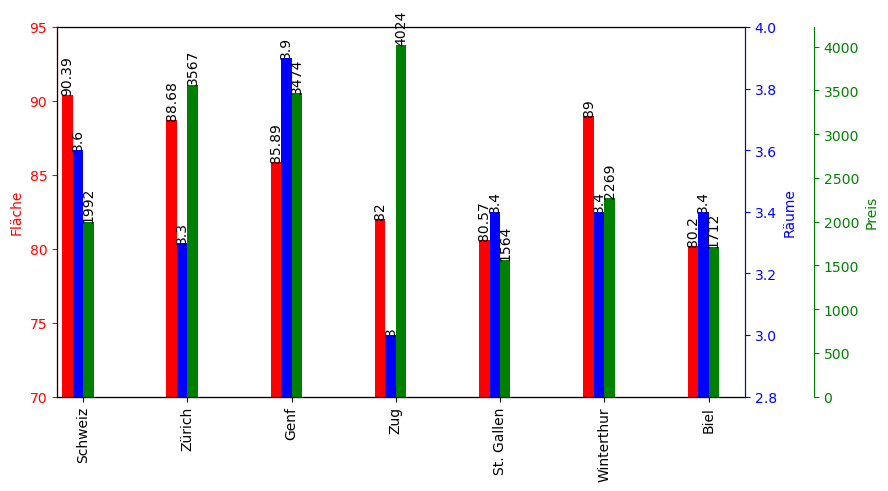

In [33]:
avg_sqm_switzerland = round(data_switzerland["Size [m²]"].mean(),2)
avg_rooms_switzerland = round(data_switzerland["Number of Rooms"].mean(),1)
avg_price_switzerland = round(data_switzerland["Price [CHF]"].mean())

avg_sqm_zurich = round(data_zurich["Size [m²]"].mean(),2)
avg_rooms_zurich = round(data_zurich["Number of Rooms"].mean(),1)
avg_price_zurich = round(data_zurich["Price [CHF]"].mean())

avg_sqm_genf = round(data_genf["Size [m²]"].mean(),2)
avg_rooms_genf = round(data_genf["Number of Rooms"].mean(),1)
avg_price_genf = round(data_genf["Price [CHF]"].mean())

avg_sqm_zug = round(data_zug["Size [m²]"].mean(),2)
avg_rooms_zug = round(data_zug["Number of Rooms"].mean(),1)
avg_price_zug = round(data_zug["Price [CHF]"].mean())

avg_sqm_stgallen = round(data_stgallen["Size [m²]"].mean(),2)
avg_rooms_stgallen = round(data_stgallen["Number of Rooms"].mean(),1)
avg_price_stgallen = round(data_stgallen["Price [CHF]"].mean())

avg_sqm_winterthur = round(data_winterthur["Size [m²]"].mean(),2)
avg_rooms_winterthur = round(data_winterthur["Number of Rooms"].mean(),1)
avg_price_winterthur = round(data_winterthur["Price [CHF]"].mean())

avg_sqm_biel = round(data_biel["Size [m²]"].mean(),2)
avg_rooms_biel = round(data_biel["Number of Rooms"].mean(),1)
avg_price_biel = round(data_biel["Price [CHF]"].mean())

df=pd.DataFrame({
    'Fläche': (avg_sqm_switzerland, avg_sqm_zurich, avg_sqm_genf, avg_sqm_zug, avg_sqm_stgallen, avg_sqm_winterthur, avg_sqm_biel),
    'Räume': (avg_rooms_switzerland, avg_rooms_zurich, avg_rooms_genf, avg_rooms_zug, avg_rooms_stgallen, avg_rooms_winterthur, avg_rooms_biel),
    'Preis': (avg_price_switzerland, avg_price_zurich, avg_price_genf, avg_price_zug, avg_price_stgallen, avg_price_winterthur,avg_price_biel)},
index= ["Schweiz", "Zürich", "Genf", "Zug", "St. Gallen", "Winterthur", "Biel"])



fig, ax = plt.subplots()
fig.subplots_adjust(right=1.2)


ax2 = ax.twinx()
ax3 = ax.twinx()

width = 0.1

df.Fläche.plot(kind='bar', color='red', ax=ax, width=width, position=2, use_index=True)
df.Räume.plot(kind='bar', color='blue', ax=ax2,  width=width, position=1, use_index=True)
df.Preis.plot(kind='bar', color='green', ax=ax3, width=width, position=0, use_index=True)


ax.set_ylabel('Fläche')
ax.set_ylim([70,95])
ax.spines.left.set_color('red')
ax.tick_params(axis='y', colors='red')
ax.yaxis.label.set_color('red')

for container in ax.containers:
    ax.bar_label(container, rotation='vertical')
    
ax2.set_ylabel('Räume')
ax2.set_ylim([2.8,4])
ax2.spines.right.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax2.yaxis.label.set_color('blue')

for container in ax2.containers:
    ax2.bar_label(container, rotation='vertical')

ax3.set_ylabel('Preis')
ax3.spines.right.set_position(("axes", 1.1))
ax3.spines.right.set_color('green')
ax3.tick_params(axis='y', colors='green')
ax3.yaxis.label.set_color('green')

for container in ax3.containers:
    ax3.bar_label(container, rotation='vertical')

plt.show()

## 6. EDA mixed with Keras

#### 6.1 Wohnungsgrösse zu Preis

2023-05-06 16:49:39.284254: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-06 16:49:39.419435: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-06 16:49:39.964022: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-06 16:49:39.965501: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 16:49:42.996414: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Epoch 1/100
159/159 [==============================] - 1s 2ms/step - loss: 1242198.5000
Epoch 2/100
159/159 [==============================] - 1s 3ms/step - loss: 949621.0625
Epoch 3/100
159/159 [==============================] - 1s 3ms/step - loss: 952982.3750
Epoch 4/100
159/159 [==============================] - 0s 3ms/step - loss: 946855.2500
Epoch 5/100
159/159 [==============================] - 0s 2ms/step - loss: 943934.6875
Epoch 6/100
159/159 [==============================] - 0s 2ms/step - loss: 944310.0625
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 958380.8125
Epoch 8/100
159/159 [==============================] - 0s 2ms/step - loss: 953469.3750
Epoch 9/100
159/159 [==============================] - 0s 2ms/step - loss: 950201.3750
Epoch 10/100
159/159 [==============================] - 0s 2ms/step - loss: 949748.5000
Epoch 11/100
159/159 [==============================] - 1s 3ms/step - loss: 946307.2500
Epoch 12/100
159/159 [==================

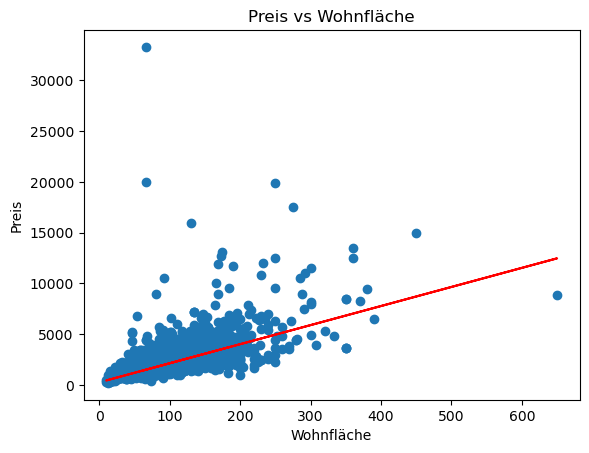

In [83]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

# Laden des Excel-Files in ein Pandas DataFrame
df = pd.read_excel('output_for_plot.xlsx')

# Entfernen von Zeilen mit NaN-Werten in der Spalte "number_of_rooms"
df = df.dropna(subset=['number_of_rooms'])

# Entfernen von Zeilen mit 'None' in der Spalte "number_of_rooms"
df = df[df['number_of_rooms'] != 'None']

# Konvertieren der Spalten "flat_size" und "flat_price_chf" in Float-Datentypen
df['flat_size'] = df['flat_size'].astype(float)
df['flat_price_chf'] = df['flat_price_chf'].astype(float)

# Aufteilen der Daten in Trainings- und Testdaten
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)

# Definition des Modells
model = keras.Sequential([
    keras.layers.Dense(units=1, input_shape=[1])
])

# Kompilieren des Modells
model.compile(optimizer=tf.optimizers.Adam(1), loss='mean_squared_error')

# Training des Modells
history = model.fit(train_data['flat_size'], train_data['flat_price_chf'], epochs=100)

# Evaluieren des Modells
test_loss = model.evaluate(test_data['flat_size'], test_data['flat_price_chf'])
print('Test Loss:', test_loss)

# Plotten der Ergebnisse
plt.scatter(df['flat_size'], df['flat_price_chf'])
plt.plot(df['flat_size'], model.predict(df['flat_size']), color='red')
plt.xlabel('Wohnfläche')
plt.ylabel('Preis')
plt.title('Preis vs Wohnfläche')
plt.show()

#### 6.2 Preis pro Raum

40/40 [==============================] - 0s 2ms/step


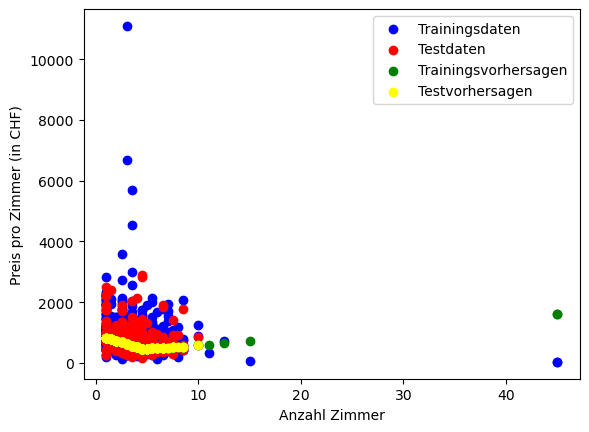

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Laden des Excel-Files in ein Pandas DataFrame
df = pd.read_excel('output_for_plot.xlsx')

# Entfernen von Zeilen mit NaN-Werten in der Spalte "number_of_rooms"
df = df.dropna(subset=['number_of_rooms'])

# Entfernen von Zeilen mit 'None' in der Spalte "number_of_rooms"
df = df[df['number_of_rooms'] != 'None']

# Konvertieren der Spalten "number_of_rooms" und "flat_price_chf" in Float-Datentypen
df['number_of_rooms'] = df['number_of_rooms'].astype(float)
df['flat_price_chf'] = df['flat_price_chf'].astype(float)

# Berechnen des Preises pro Zimmer
df['price_per_room'] = df['flat_price_chf'] / df['number_of_rooms']

# Aufteilung in Trainings- und Testdaten
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

# Extrahieren der Merkmale (Features) und Zielvariablen (Targets)
train_features = train_df[['number_of_rooms']].values
train_labels = train_df['price_per_room'].values
test_features = test_df[['number_of_rooms']].values
test_labels = test_df['price_per_room'].values

# Normalisieren der Features
train_mean = train_features.mean()
train_std = train_features.std()
train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

# Definition des Modells
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(1)
])

# Kompilieren des Modells
model.compile(optimizer='adam', loss='mse')

# Training des Modells
history = model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split=0.2)

# Vorhersagen für Trainings- und Testdaten
train_predictions = model.predict(train_features)
test_predictions = model.predict(test_features)

# Erstellen des Scatterplots für die Daten und Vorhersagen
plt.scatter(train_df['number_of_rooms'], train_df['price_per_room'], color='blue', label='Trainingsdaten')
plt.scatter(test_df['number_of_rooms'], test_df['price_per_room'], color='red', label='Testdaten')
plt.scatter(train_df['number_of_rooms'], train_predictions, color='green', label='Trainingsvorhersagen')
plt.scatter(test_df['number_of_rooms'], test_predictions, color='yellow', label='Testvorhersagen')
plt.xlabel('Anzahl Zimmer')
plt.ylabel('Preis pro Zimmer (in CHF)')
plt.legend()
plt.show()

#### 6.3 Preis zu Quadratmeter

Epoch 1/100
159/159 [==============================] - 1s 3ms/step - loss: 438.1326
Epoch 2/100
159/159 [==============================] - 0s 2ms/step - loss: 210.1762
Epoch 3/100
159/159 [==============================] - 0s 3ms/step - loss: 178.3276
Epoch 4/100
159/159 [==============================] - 1s 3ms/step - loss: 157.2361
Epoch 5/100
159/159 [==============================] - 1s 3ms/step - loss: 142.9928
Epoch 6/100
159/159 [==============================] - 0s 2ms/step - loss: 134.1434
Epoch 7/100
159/159 [==============================] - 1s 3ms/step - loss: 131.3883
Epoch 8/100
159/159 [==============================] - 1s 3ms/step - loss: 130.9383
Epoch 9/100
159/159 [==============================] - 0s 3ms/step - loss: 133.2829
Epoch 10/100
159/159 [==============================] - 0s 2ms/step - loss: 132.1450
Epoch 11/100
159/159 [==============================] - 0s 2ms/step - loss: 130.0489
Epoch 12/100
159/159 [==============================] - 1s 3ms/step - loss

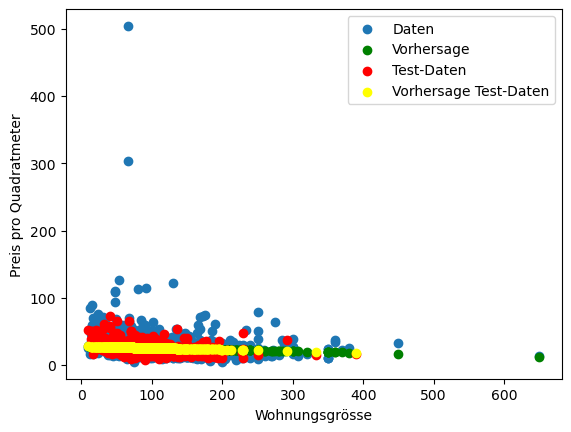

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Laden des Excel-Files in ein Pandas DataFrame
df = pd.read_excel('output_for_plot.xlsx')

# Entfernen von Zeilen mit NaN-Werten in der Spalte "number_of_rooms"
df = df.dropna(subset=['number_of_rooms'])

# Entfernen von Zeilen mit 'None' in der Spalte "number_of_rooms"
df = df[df['number_of_rooms'] != 'None']

# Konvertieren der Spalten "flat_size" und "flat_price_chf" in Float-Datentypen
df['flat_size'] = df['flat_size'].astype(float)
df['flat_price_chf'] = df['flat_price_chf'].astype(float)

# Berechnen des Preises pro Quadratmeter
df['price_per_sqm'] = df['flat_price_chf'] / df['flat_size']

# Aufteilen der Daten in Trainings- und Testdaten
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

# Definieren der Eingabe-Features (Wohnungsgröße)
train_features = train_dataset[['flat_size']]
test_features = test_dataset[['flat_size']]

# Definieren der Ausgabe-Labels (Preis pro Quadratmeter)
train_labels = train_dataset[['price_per_sqm']]
test_labels = test_dataset[['price_per_sqm']]

# Definition des Modells
model = keras.Sequential([
    keras.layers.Dense(1, input_shape=[1])
])

# Kompilieren des Modells
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.1))

# Trainieren des Modells
history = model.fit(train_features, train_labels, epochs=100)

# Vorhersagen treffen
train_predictions = model.predict(train_features).flatten()
test_predictions = model.predict(test_features).flatten()

# Erstellen des Scatterplots für Wohnungsgröße und Preis pro Quadratmeter
plt.scatter(train_features, train_labels, label='Daten')
plt.scatter(train_features, train_predictions, color='green', label='Vorhersage')
plt.scatter(test_features, test_labels, color='red', label='Test-Daten')
plt.scatter(test_features, test_predictions, color='yellow', label='Vorhersage Test-Daten')
plt.xlabel('Wohnungsgrösse')
plt.ylabel('Preis pro Quadratmeter')
plt.legend()
plt.show()

#### 6.4 Vergleich ZH / SG

21/21 [==============================] - 0s 2ms/step


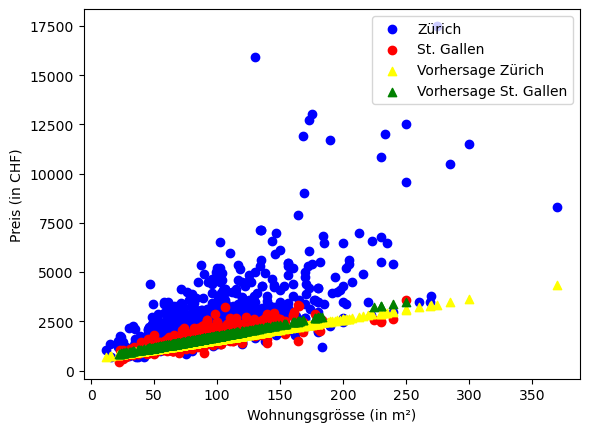

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Laden des Excel-Files in ein Pandas DataFrame
df = pd.read_excel('output_for_plot.xlsx')

# Filtern des DataFrames mit einem regulären Ausdruck für "addr_zip" als erste Ziffer eine 8 oder 9
df_8 = df[df['addr_zip'].astype(str).str.startswith('8')]
df_9 = df[df['addr_zip'].astype(str).str.startswith('9')]

# Extrahieren der Merkmale (Features) und Zielvariablen (Targets)
x_8 = df_8[['flat_size', 'number_of_rooms']].values
y_8 = df_8['flat_price_chf'].values
x_9 = df_9[['flat_size', 'number_of_rooms']].values
y_9 = df_9['flat_price_chf'].values

# Normalisieren der Features
x_8 = (x_8 - x_8.mean()) / x_8.std()
x_9 = (x_9 - x_9.mean()) / x_9.std()

# Definition des Modells
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(1)
])

# Kompilieren des Modells
model.compile(optimizer='adam', loss='mse')

# Training des Modells auf den Daten der PLZ mit 8 beginnend
model.fit(x_8, y_8, epochs=100, verbose=0)

# Vorhersagen für die Daten der PLZ mit 8 beginnend
y_8_pred = model.predict(x_8)

# Training des Modells auf den Daten der PLZ mit 9 beginnend
model.fit(x_9, y_9, epochs=100, verbose=0)

# Vorhersagen für die Daten der PLZ mit 9 beginnend
y_9_pred = model.predict(x_9)


# Erstellen des Scatterplots für die ursprünglichen Daten mit unterschiedlicher Farbe für jede Gruppe
plt.scatter(df_8['flat_size'], df_8['flat_price_chf'], color='blue', label='Zürich')
plt.scatter(df_9['flat_size'], df_9['flat_price_chf'], color='red', label='St. Gallen')

# Hinzufügen der Vorhersagepunkte als grüne Dreiecke
plt.scatter(df_8['flat_size'], y_8_pred, color='yellow', marker='^', label='Vorhersage Zürich')
plt.scatter(df_9['flat_size'], y_9_pred, color='green', marker='^', label='Vorhersage St. Gallen')

plt.xlabel('Wohnungsgrösse (in m²)')
plt.ylabel('Preis (in CHF)')
plt.legend()
plt.show()